# Network Trainer

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

### Data Transformation
We need to prepare the data before feeding it to the network. This transformation also has to be applied to the images we use as input for prediction later. Therefore we have to include it in the ROS processor node.

- **transforms.ToTensor()** - converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
- **transforms.Normalize()** - normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

### Load the MNIST Dataset
We load the MNIST dataset in two chunks: 60000 data samples for training and 1000 data samples for validation. 

In [4]:
# Download the dataset and apply the transformation.
trainset = datasets.MNIST('Datasets/Train', download=True, train=True, transform=transform)
valset = datasets.MNIST('Datasets/Validate', download=True, train=False, transform=transform)

In [10]:
# Prepare data loaders to feed the network batches of random images.
loader_train = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
loader_test = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Data Exploration

In [12]:
# We want to get information of the tensor shapes.
data_iterator = iter(loader_train)
images, labels = data_iterator.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


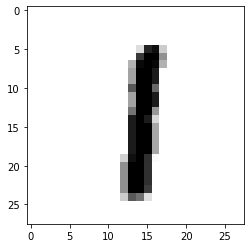

In [13]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

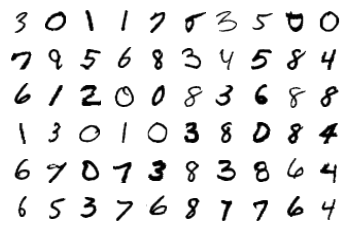

In [14]:
figure = plt.figure()
num_of_images = 60

for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Build the Neural Network

In [15]:
# The input size is one unwrapped image (1 x 28 x 28).
# We get 784 neurons as the input layer.
input_size = 784
# The first hidden layer has 128 and the secon 64.
hidden_sizes = [128, 64]
# The output layer has ten neurons for the numbers 0-9.
output_size = 10
# Build the model by chaining up the layers sequentially.
# We use ReLU as the activation function.
# The softmax function at the end does the classification.
# This will select the one out of ten neurons which scores best.
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


### Define the Loss Function
Next, we define the negative log-likelihood loss. It is useful to train a classification problem with C classes. Together the LogSoftmax() and NLLLoss() acts as the cross-entropy loss.

In [16]:
# negative log-likelihood loss
criterion = nn.NLLLoss()
images, labels = next(iter(loader_train))
# TODO Examine this a bit further!
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [17]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        [ 0.0029,  0.0029,  0.0029,  ...,  0.0029,  0.0029,  0.0029],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009]])


### Train the Model

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15

losses = []

for e in range(epochs):
    running_loss = 0
    
    for images, labels in loader_train:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating.
        loss.backward()
        
        # And optimizes its weights here.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        # Store the epoch losses for plotting later.
        loss_epoch = running_loss / len(loader_train)
        losses.append(loss_epoch)
        print("Epoch {} - Training loss: {}".format(e, loss_epoch))
        
print("\nTraining Time (in minutes) =",(time() - time0) / 60)

Epoch 0 - Training loss: 0.6392275783489508
Epoch 1 - Training loss: 0.28996194629018496
Epoch 2 - Training loss: 0.22325369469853226
Epoch 3 - Training loss: 0.17736360557806263
Epoch 4 - Training loss: 0.1447343140927904
Epoch 5 - Training loss: 0.12408590504228434
Epoch 6 - Training loss: 0.10859469405220532
Epoch 7 - Training loss: 0.09558275026847114
Epoch 8 - Training loss: 0.08707611371072005
Epoch 9 - Training loss: 0.0785351623225012
Epoch 10 - Training loss: 0.07070914047535883
Epoch 11 - Training loss: 0.06557939829690053
Epoch 12 - Training loss: 0.059849739536148576
Epoch 13 - Training loss: 0.05470339738965424
Epoch 14 - Training loss: 0.050260696997756815

Training Time (in minutes) = 3.7688212831815084


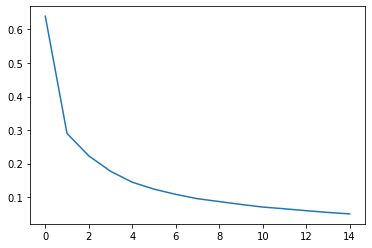

In [20]:
def plot_loss_curve(losses):
    plt.plot(losses)
    
plot_loss_curve(losses)

### Validation

In [22]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 8


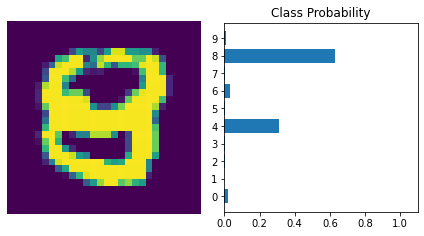

In [23]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Now we iterate through the validation set using a for loop and calculate the total number of correct predictions. This is how we can calculate the accuracy.

In [27]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9721


### Save Model

In [26]:
torch.save(model, './Models/mnist_model_01.pt') 

### Sources:
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627